https://python.langchain.com/docs/tutorials/sql_qa/

In [12]:


import re
from langchain_ollama import ChatOllama
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated
from typing_extensions import TypedDict
from langchain_core.prompts import PromptTemplate

#TypedDicts like State define what fields are expected in the Python object 
#passed between steps, functions, or graph nodes.

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

class QueryOutput(TypedDict):
    query: str

db = SQLDatabase.from_uri("sqlite:///finances.db")
 
 
llm = ChatOllama(model="llama3.1", temperature=0)


print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM pocketsmith LIMIT 10;")
 

sqlite
['pocketsmith']


"[('2025-09-24', 'OPERAPARIS SXINT2382385', None, -276.2, 'USD', -235.22, 'EUR', 'debit', 'CREDIT CARD', -3327.02, 'Food and Drink', None, None, None, None, 1473885249), ('2025-09-05', 'CHASE CREDIT CRD EPAY 250903 8694885180 WALKER E ROWE', None, -167.62, 'USD', -143.0, 'EUR', 'debit', 'CHECKING ...2255', 35.96, 'Payment', None, None, None, None, 1450618980), ('2025-09-04', 'Payment Thank You-Mobile', None, 167.62, 'USD', 143.8, 'EUR', 'credit', 'CREDIT CARD', -3050.82, 'Payment', None, None, None, None, 1451066313), ('2025-09-04', 'LENDINGPOINT LLC PAYMENT 250903 LPT33997373 LAI00652490 LPT33997373', None, -158.73, 'USD', -136.17, 'EUR', 'debit', 'CHECKING ...2255', 203.58, 'Loans', None, None, None, None, 1450618977), ('2025-09-03', 'SOCIAL SECURITY XXSOC SEC 250903 XXXXX3061A SSA WALKER E ROWE', None, 2005.2, 'USD', 1719.58, 'EUR', 'credit', 'CHECKING ...2255', 2065.2, 'Income', None, None, None, None, 1448956626), ('2025-09-02', 'REMOTEROCKETSHIP.COM', None, -63.0, 'USD', -54.16, 

# Chains
Chains are compositions of predictable steps. In LangGraph, we can represent a chain via simple sequence of nodes. Let's create a sequence of steps that, given a question, does the following:

* converts the question into a SQL query;
* executes the query;
* uses the result to answer the original question.

# Application state

The LangGraph state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

In [13]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

# Convert question to SQL query

The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's SQLDatabase object includes methods to help with this. Our write_query step will just populate these parameters and prompt a model to generate the SQL query:

In [14]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


In [15]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [16]:
write_query({"question": "How many Employees are there?"})

{'query': "SELECT COUNT(*) FROM pocketsmith WHERE transaction_type = 'debit'"}

# Execute Query

In [17]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [18]:
execute_query({"query": "SELECT COUNT(*) FROM pocketsmith;"})

{'result': '[(5498,)]'}

# Generate answer

Finally, our last step generates an answer to the question given the information pulled from the database:

In [19]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

# Orchestrating with LangGraph

Finally, we compile our application into a single graph object. In this case, we are just connecting the three steps into a single sequence.

In [20]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

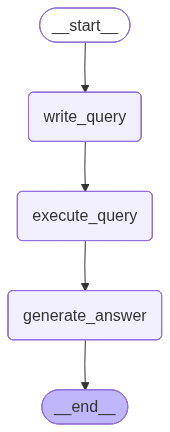

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
for step in graph.stream(
    {"question": "Have average expenses gone down or up since 2021"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT AVG(amount) AS avg_amount, transaction_type FROM pocketsmith WHERE date > '2021-01-01' GROUP BY transaction_type"}}
{'execute_query': {'result': "[(719.6779726651481, 'credit'), (-69.0738705835649, 'debit')]"}}
{'generate_answer': {'answer': "Based on the SQL result, it appears that average credit card expenses have gone up since 2021 (719.68), while average debit card expenses have gone down (69.07). \n\nSo, to answer your question: Average expenses have both gone up and down since 2021, depending on whether you're looking at credit or debit transactions."}}
